In [1]:
import os
import pickle
from tqdm import tqdm
import sentencepiece as spm

In [2]:
source_folder = '/scratche/home/apoorv/repos/probe_kge/data/wnrr'
! ls {source_folder}

dataset.yaml	    test.txt		     valid.del
entity_ids.del	    test_without_unseen.del  valid.txt
entity_strings.del  train.del		     valid_without_unseen.del
relation_ids.del    train_sample.del
test.del	    train.txt


In [3]:
def readTriples(fname):
    f = open(fname)
    triples = []
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        triples.append(line.split('\t'))
    f.close()
    return triples

In [4]:
# load half data
data = {}
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(source_folder, split + '.txt')
    data[split] = readTriples(fname)

In [5]:
data['train'][5000]

['09429387', '_hypernym', '09385911']

In [6]:
len(data['train'])

86835

In [7]:
uniq_tails = set()
for t in data['train']:
    uniq_tails.add(t[2])
len(uniq_tails)

31881

In [8]:
def getPOS(name):
    return name[2:].split('_')[-2]

def processDefinition(definition):
    if '\"' in definition and ':' in definition:
        out = definition.split(':')[0]
    if ';' in definition:
        out = definition.split(';')[0]
    else:
        out = definition
    return out

def getAlias(name, definition):
    pos = getPOS(name)
    name = ' '.join(name[2:].split('_')[:-2])
    definition = processDefinition(definition)
    out = name + ', ' + pos + ' -- ' + definition
    return out

In [11]:
dest_folder = '/scratche/home/apoorv/transformer-kgc/data/wnrr_shuffled'
aliases_dict = {}
# fname = os.path.join(dest_folder, 'wn-entity2text-new.txt')
fname = os.path.join(dest_folder, 'wordnet-mlj12-definitions.txt')
ent_names = []
definitions = []
aliases_set = set()
f = open(fname)
for line in f:
    line = line.rstrip().split('\t')
    ent_names.append(line[1])
    definitions.append(line[2])
    alias = getAlias(line[1], line[2])
    if alias in aliases_set:
        print(line, alias)
        alias = alias + ' 2'
    else:
        aliases_set.add(alias)
    aliases_dict[line[0]] = alias
f.close()

['02154312', '__spy_VB_1', 'catch sight of'] spy, VB -- catch sight of
['02073545', '__throw_off_VB_2', 'get rid of; "I couldn\'t shake the car that was following me"'] throw off, VB -- get rid of
['01397088', '__whop_VB_2', 'hit hard'] whop, VB -- hit hard
['00090708', '__mutilate_VB_3', 'destroy or injure severely; "mutilated bodies"'] mutilate, VB -- destroy or injure severely
['01872772', '__spiny_anteater_NN_1', 'a burrowing monotreme mammal covered with spines and having a long snout and claws for hunting ants and termites; native to New Guinea'] spiny anteater, NN -- a burrowing monotreme mammal covered with spines and having a long snout and claws for hunting ants and termites


In [12]:
len(aliases_dict), len(set(aliases_dict.values()))

(40943, 40943)

In [16]:
import random
# shuffle aliases_dict
temp = list(aliases_dict.values())
random.shuffle(temp)
res = dict(zip(aliases_dict, temp))
aliases_dict_shuffled = res

In [22]:
# forget original
aliases_dict = aliases_dict_shuffled

In [23]:
count = 0
for k, v in aliases_dict.items():
    print(v)
    count += 1
    if count == 100:
        break

circumvention, NN -- the act of evading by going around
mod con, NN -- modern convenience
transfuse, VB -- treat by applying evacuated cups to the patient's skin
himantopus mexicanus, NN -- stilt of southwestern United States to northern South America having black plumage extending from the head down the back of the neck
storage area, NN -- the space in a ship or aircraft for storing cargo
brutalization, NN -- the activity of treating someone savagely or viciously
macadam, NN -- broken stone used in macadamized roadways
repetition, NN -- the act of doing or performing again
volunteer, VB -- do volunteer work
mentha, NN -- mint plants
printing machine, NN -- a machine that prints
witchery, NN -- the art of sorcery
presumptuousness, NN -- audacious (even arrogant) behavior that you have no right to
family cymatiidae, NN -- tritons
cross question, VB -- question closely, or question a witness that has already been questioned by the opposing side
third-rater, NN -- one who is third-rate or

In [24]:
def triple2text(t):
    global aliases_dict
    rel = ' '.join(t[1][1:].split('_'))
    out = [aliases_dict[t[0]], rel, aliases_dict[t[2]]]
    return out

In [25]:
for t in data['train'][10:20]:
    print(triple2text(t))

['pseudaletia unipuncta, NN -- moth whose destructive larvae travel in multitudes', 'hypernym', 'individualize, VB -- make or mark or treat as individual']
['passionflower vine, NN -- any of various chiefly tropical American vines some bearing edible fruit', 'also see', 'suggest, VB -- imply as a possibility']
['sensitivity, NN -- sensitivity to emotional feelings (of self and others)', 'hypernym', 'allyl radical, NN -- the univalent unsaturated organic radical C3H5']
['oestrogen, NN -- a general term for female steroid sex hormones that are secreted by the ovary and responsible for typical female sexual characteristics', 'hypernym', 'rough, JJ -- of the margin of a leaf shape']
['thwarter, NN -- someone who systematically obstructs some action that others want to take', 'hypernym', 'palaemon, NN -- type genus of the family Palaemonidae']
['charge, VB -- cause formation of a net electrical charge in or on', 'member meronym', 'genus echinacea, NN -- small genus of North American coarse 

In [26]:
from transformers import T5TokenizerFast
tokenizer = T5TokenizerFast.from_pretrained('t5-small')

In [27]:
from tqdm.notebook import tqdm
lengths = []
for k, v in tqdm(aliases_dict.items()):
    x = tokenizer(v)
    lengths.append(len(x['input_ids']))

Text(0.5, 0, 'Tokenized lengths')

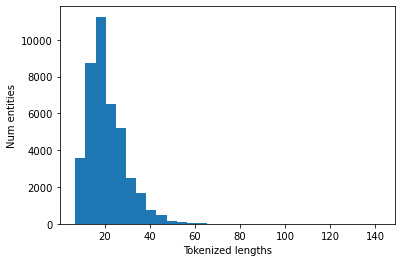

In [28]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [29]:
len(aliases_dict)

40943

In [30]:
def mapTriple(t, aliases_dict):
    out = triple2text(t)
    return out

In [31]:
for id in range(500):
    print(mapTriple(data['train'][id], aliases_dict))

['rumohra, NN -- leatherleaf ferns: in some classifications included in genus Polystichum', 'hypernym', 'carson city, NN -- capital of the state of Nevada']
['stutterer, NN -- someone who speaks with involuntary pauses and repetitions', 'derivationally related form', 'film, VB -- record in film']
['penutian, NN -- a family of Amerindian language spoken in the great interior valley of California', 'derivationally related form', 'stemma, NN -- an eye having a single lens']
['wv, NN -- a state in east central United States', 'instance hypernym', 'relationship, NN -- a state involving mutual dealings between people or parties or countries']
['roll, NN -- the act of throwing dice', 'derivationally related form', 'holdup, NN -- the act of delaying']
['recount, NN -- an additional (usually a second) count', 'derivationally related form', 'skid, VB -- elevate onto skids']
['honorary society, NN -- an institution for the advancement of art or science or literature', 'hypernym', 'story, NN -- a 

In [32]:
len(data['train'])

86835

In [33]:
out_folder = dest_folder
splits = ['train', 'test', 'valid']

count = 0
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        
        t = mapTriple(t, aliases_dict)
        # only save those that DO NOT start with m. or g.
        # we can do that since aim is KGQA not KGC
        head, relation, tail = t
        input = 'predict tail: {0} | {1}'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1}'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

In [34]:
count

0

In [35]:
entity_names = set()
for key, value in aliases_dict.items():
#     if key.startswith('Q'):
    entity_names.add(value)
len(entity_names)

40943

In [36]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = entity_names
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [99]:
# webqsp qa 
# def readQALines(fname):
#     f = open(fname)
#     questions = []
#     for line in f:
#         line = line.strip().split('\t')
#         q = line[0]
#         lhs = q.split('[')[0]
#         rhs = q.split(']')[1]
#         only_question = lhs + 'NE' + rhs
#         only_question = normalizeEntity(only_question)
# #         q = q.replace('[', '')
# #         q = q.replace(']', '')
# #         q = normalizeEntity(q)
#         questions.append(only_question)
#     return questions
        
# def writeLines(lines, fname):
#     f = open(fname, 'w')
#     for line in lines:
#         f.write(line + '\n')


'what character did natalie portman play in star wars NE'

In [81]:
# fname = 'data/MetaQA/full_qa.txt'
# questions = readQALines(fname)
# questions = list(set(questions))

In [82]:
# fname = 'data/MetaQA/only_questions_text.txt'
# writeLines(questions, fname)

In [138]:
vocab_size = 30000
sp = spm.SentencePieceTrainer.train(input='data/fbwq_half/train.txt', 
                                    model_prefix='fbwq_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['predict',
#                                                     'head',
#                                                     'tail',
#                                                     '|'],
#                                     normalization_rule_name='identity',
                              )

In [139]:
# sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')
sp = spm.SentencePieceProcessor(model_file='fbwq_with_pad.model')

In [38]:
# sp['Obama']

0

In [151]:
sp.decode(sp.encode('how old'))

'how old'

In [192]:
sp.encode('<pad>')

[5, 0, 12497, 0]

In [195]:
sp['</s>']

2

In [193]:
sp.id_to_piece(3)

'<pad>'

In [176]:
lengths = []
count = 0
for e in tqdm(ents_uniq):
    encoded = sp.encode(e)
    l = len(encoded)
    if l > 500:
        print(e,l)
        l = 20
        count += 1
    lengths.append(l)
count

100%|██████████| 1712213/1712213 [00:18<00:00, 91029.72it/s] 


0

Text(0.5, 0, 'Tokenized lengths')

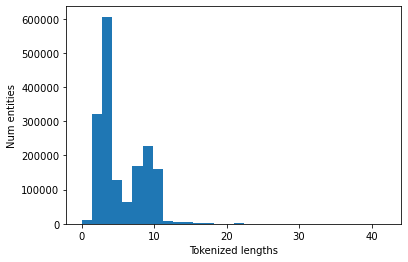

In [177]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [190]:
lengths = []
count = 0
for e in tqdm(relations):
    encoded = sp.encode(relation_map[e])
    l = len(encoded)
    if l > 10:
        print(relation_map[e])
        count +=1
    lengths.append(l)
count

100%|██████████| 1068/1068 [00:00<00:00, 41292.34it/s]

astronomical objects discovered
astronomical objects discovered reverse
sewage treatment plant
sewage treatment plant reverse
infidelity perpetrator reverse
substance abuse reverse
lifetime batting statistics reverse
sponsored by reverse
substance abuse problems reverse
appears in these fictional universes reverse
jurisdiction of office reverse
body this is a component of reverse
politicians in this party reverse
websites owned reverse
tropical cyclone season reverse
olympics hosted reverse
types of places of worship reverse
athletic performances reverse
mode of transportation reverse
appeared in tv episodes reverse
episodes appeared in reverse


21

Text(0.5, 0, 'Tokenized lengths')

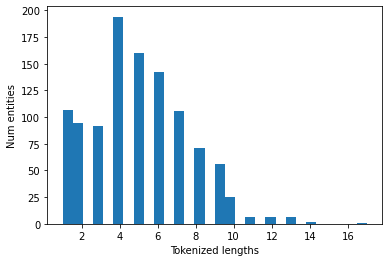

In [186]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [191]:
sp.encode('plays for')

[167, 10, 96]

In [104]:
len(uniq_ent_map)

1880592

In [143]:
def replaceEntities(line, aliases_dict):
    line = line.strip().split('\t')
    q = line[0]
    # sometimes no answer
    if len(line) > 1:
        answers= line[1].split('|')
    else:
        answers = []    
    lhs = q.split('[')[0]
    rhs = q.split(']')[1]
    head_id = q.split('[')[1].split(']')[0]
    if head_id in aliases_dict:
        head_text = aliases_dict[head_id]
    else:
        head_text = head_id
        print(head_text + ' not found')
    answers_text = []
    for a in answers:
        if a in aliases_dict:
            answers_text.append(aliases_dict[a])
        else:
            answers_text.append(a)
    answers_string = '|'.join(answers_text)
    
    out = '{lhs}[{head}]{rhs}\t{ans}'.format(
        lhs=lhs,
        rhs=rhs,
        head = head_text,
        ans = answers_string
    )
    return out
        
def readLines(fname):
    f = open(fname)
    lines = []
    for line in f:
        lines.append(line.rstrip())
    f.close()
    return lines

def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [137]:
# need to make qa data as well, since entity aliases need to be used
# and not just entity ids as answers
fname = '/scratche/home/apoorv/EmbedKGQA/data/QA_data/WebQuestionsSP/qa_test_webqsp_fixed.txt'
questions = readLines(fname)


In [138]:
questions[1]

'what did james k polk do before he was president [m.042f1]\tm.02_bcst|m.04x_n9q|m.0cgqx'

In [144]:
lines_with_entities = [replaceEntities(q, uniq_ent_map) for q in questions]

m.02vkmj9 not found


In [145]:
len(lines_with_entities)

1639

In [146]:
lines_with_entities[:10]

['what does jamaican people speak [Jamaica 1]\tJamaican English|Jamaican Creole English Langua|Jamaican English',
 'what did james k polk do before he was president [James K. Polk]\tUnited States Representative|Governor of Tennessee|Speaker of the United States H',
 'who plays ken barlow in coronation street [Coronation Street]\tWilliam Roache',
 'where is jamarcus russell from [JaMarcus Russell]\tMobile 0',
 'where was george washington carver from [George Washington Carver]\tDiamond 8',
 'what else did ben franklin invent [Benjamin Franklin]\tLightning rod|Bifocals|Glass harmonica|Franklin stove',
 'who was richard nixon married to [Richard Nixon]\tPat Nixon',
 'who is governor of ohio 2011 [Ohio 2]\tJohn Kasich|Return J. Meigs, Jr.|Ted Strickland',
 'who was vice president after kennedy died [John F. Kennedy 0]\tLyndon B. Johnson 1',
 'where is the fukushima daiichi nuclear plant located [Fukushima Daiichi Nuclear Powe]\tJapan 1|Okuma']

In [148]:
fname = 'data/fbwq_half/qa_valid_1hop.txt'
writeLines(lines_with_entities, fname)